In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import rasterio as rio
import geopandas as gp

import fiona 
import rasterio
import rasterio.mask

import matplotlib.pyplot as plt
from collections import OrderedDict 

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from rasterio.mask import mask
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D      

from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

from osgeo import gdal, osr, ogr
from tqdm import tqdm

In [2]:
# read files setup dirs for Seasonal results
gdf = gp.read_file("../shape/sierra_catchments.shp")
seasonal_dir = "../rasters/seasonal_fin"
outdir = "../rasters/seasonal_merged"

if not os.path.exists(outdir):
    os.mkdir(outdir)

# Setup iterables of seasons and vars to loop thru 
seasons = ['W','Sp','Su','F']
p_vars = ['plag','pcor','pmi','pte','pjsd']
d_vars = ['dlag','dcor','dmi','dte','djsd']

# Clip the rasters to the watershed boundaries 
for idx, x in enumerate(gdf[:].iterrows()):
    print("****" * 15)

    row  = x[1]
    stn_id = row['stid']
    print("PROCESSING : ", stn_id, row['catch_name'])

    # loop through seasons 
    for season in tqdm(seasons[:]):
        sfiles = [os.path.join(seasonal_dir,x) for x in os.listdir(seasonal_dir) if season in x and stn_id in x]

        # loop through precip vars
        for hvar in p_vars[:]:
            
            # setup write dir
            vardir = os.path.join(outdir,hvar)
            if not os.path.exists(vardir):
                os.mkdir(vardir)

            # Get the fns which match the var 
            varfiles = [x for x in sfiles if hvar in x]

            # First clip rasters to shp 
            catch_shp = "../shape/{}.shp".format(stn_id)

            # clip and write to merged/var dir (if not already done)
            for fn in varfiles:
                varfn = os.path.split(fn)[1]
                outfn = os.path.join(vardir,varfn) 
                if not os.path.exists(outfn):
                    cmd = '''gdalwarp -dstnodata -999 -cutline {} -crop_to_cutline {} {}'''.format(catch_shp, fn, outfn)
                    os.system(cmd)                 
                
            # merge and write 
            dirfiles = [os.path.abspath(os.path.join(vardir,x)) for x in os.listdir(vardir) if season in x and x.endswith(".tiff")]
            g = gdal.Warp(os.path.join(vardir,"{}_{}.tiff".format(hvar, season)), dirfiles, format="GTiff")
            g = None # Close file
            
        # loop through dswe vars
        for hvar in d_vars[:]:
            
            # setup write dir
            vardir = os.path.join(outdir,hvar)
            if not os.path.exists(vardir):
                os.mkdir(vardir)

            # Get the fns which match the var 
            varfiles = [x for x in sfiles if hvar in x]

            # First clip rasters to shp 
            catch_shp = "../shape/{}.shp".format(stn_id)

            # clip and write to merged/var dir (if not already done)
            for fn in varfiles:
                varfn = os.path.split(fn)[1]
                outfn = os.path.join(vardir,varfn) 
                if not os.path.exists(outfn):
                    cmd = '''gdalwarp -dstnodata -999 -cutline {} -crop_to_cutline {} {}'''.format(catch_shp, fn, outfn)
                    os.system(cmd)                 
                
            # merge and write 
            dirfiles = [os.path.abspath(os.path.join(vardir,x)) for x in os.listdir(vardir) if season in x and x.endswith(".tiff")]
            g = gdal.Warp(os.path.join(vardir,"{}_{}.tiff".format(hvar, season)), dirfiles, format="GTiff")
            g = None # Close file
            
    
    # Clean up the extra files we processed, leaving only the merged files. 
    for hvar in p_vars:
        vardir = os.path.join(outdir,hvar)

        rmfiles = [os.path.abspath(os.path.join(vardir,x)) for x in os.listdir(vardir) if len(os.path.split(x)[1]) > len("{}_Su.tiff".format(hvar))]
        for rmfile in rmfiles:
            os.remove(rmfile)
            
    for hvar in d_vars:
        vardir = os.path.join(outdir,hvar)

        rmfiles = [os.path.abspath(os.path.join(vardir,x)) for x in os.listdir(vardir) if len(os.path.split(x)[1]) > len("{}_Su.tiff".format(hvar))]
        for rmfile in rmfiles:
            os.remove(rmfile)
            
    

  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  ENG YUBA R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  PAR MOKELUMNE R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  MIL SAN JOAQUIN R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  ISB KERN R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  DNP TUOLUMNE R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  NML STANISLAUS R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  ORO FEATHER R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  FOL AMERICAN R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  TRM KAWEAH R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  SCC TULE R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  CFW BEAR R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  PNF KINGS R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  MCR MERCED R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  NHG CALAVERAS R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  SHA SACRAMENTO R


100%|██████████| 4/4 [00:07<00:00,  1.95s/it]


In [3]:
# read files setup dirs for Extreme event results

extreme_dirs = ["../rasters/ranked_extremes_1d/", "../rasters/ranked_extremes_3d/", "../rasters/ranked_extremes_5d/"]
outdirs = [x.replace("extremes",'merged') for x in extreme_dirs]

# make dirs 
for outdir in outdirs:
    if not os.path.exists(outdir):
        os.mkdir(outdir)

# Setup iterables of scenarios and vars to loop thru 
scenarios = ['ex']
p_vars = ['plag','pcor','pmi','pte','pjsd']
d_vars = ['dlag','dcor','dmi','dte','djsd']


for extreme_dir, outdir in zip(extreme_dirs, outdirs):
    
    print (extreme_dir)
    # Clip the rasters to the watershed boundaries 
    for idx, x in enumerate(gdf[:].iterrows()):
        print("****" * 15)

        row  = x[1]
        stn_id = row['stid']
        print("PROCESSING : ", stn_id, row['catch_name'])

        # loop through scenarios 
        for scenario in tqdm(scenarios[:]):
            sfiles = [os.path.join(extreme_dir,x) for x in os.listdir(extreme_dir) if scenario in x and stn_id in x]

            # loop through precip vars
            for hvar in p_vars[:]:

                # setup write dir
                vardir = os.path.join(outdir,hvar)
                if not os.path.exists(vardir):
                    os.mkdir(vardir)

                # Get the fns which match the var 
                varfiles = [x for x in sfiles if hvar in x]

                # First clip rasters to shp 
                catch_shp = "../shape/{}.shp".format(stn_id)

                # clip and write to merged/var dir (if not already done)
                for fn in varfiles:
                    varfn = os.path.split(fn)[1]
                    outfn = os.path.join(vardir,varfn) 
                    if not os.path.exists(outfn):
                        cmd = '''gdalwarp -dstnodata -999 -cutline {} -crop_to_cutline {} {}'''.format(catch_shp, fn, outfn)
                        os.system(cmd)                 

                # merge and write 
                dirfiles = [os.path.abspath(os.path.join(vardir,x)) for x in os.listdir(vardir) if scenario in x and x.endswith(".tiff")]
                g = gdal.Warp(os.path.join(vardir,"{}_{}.tiff".format(hvar, scenario)), dirfiles, format="GTiff")
                g = None # Close file

            # loop through dswe vars
            for hvar in d_vars[:]:

                # setup write dir
                vardir = os.path.join(outdir,hvar)
                if not os.path.exists(vardir):
                    os.mkdir(vardir)

                # Get the fns which match the var 
                varfiles = [x for x in sfiles if hvar in x]

                # First clip rasters to shp 
                catch_shp = "../shape/{}.shp".format(stn_id)

                # clip and write to merged/var dir (if not already done)
                for fn in varfiles:
                    varfn = os.path.split(fn)[1]
                    outfn = os.path.join(vardir,varfn) 
                    if not os.path.exists(outfn):
                        cmd = '''gdalwarp -dstnodata -999 -cutline {} -crop_to_cutline {} {}'''.format(catch_shp, fn, outfn)
                        os.system(cmd)                 

                # merge and write 
                dirfiles = [os.path.abspath(os.path.join(vardir,x)) for x in os.listdir(vardir) if scenario in x and x.endswith(".tiff")]
                g = gdal.Warp(os.path.join(vardir,"{}_{}.tiff".format(hvar, scenario)), dirfiles, format="GTiff")
                g = None # Close file

        # Clean up the extra files we processed, leaving only the merged files. 
        for hvar in p_vars:
            vardir = os.path.join(outdir,hvar)
            rmfiles = [os.path.abspath(os.path.join(vardir,x)) for x in os.listdir(vardir) if len(os.path.split(x)[1]) > len("{}_nex.tiff".format(hvar))]
            for rmfile in rmfiles:
                os.remove(rmfile)

        for hvar in d_vars:
            vardir = os.path.join(outdir,hvar)
            rmfiles = [os.path.abspath(os.path.join(vardir,x)) for x in os.listdir(vardir) if len(os.path.split(x)[1]) > len("{}_nex.tiff".format(hvar))]
            for rmfile in rmfiles:
                os.remove(rmfile)


  0%|          | 0/1 [00:00<?, ?it/s]

../rasters/ranked_extremes_1d/
************************************************************
PROCESSING :  ENG YUBA R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  PAR MOKELUMNE R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  MIL SAN JOAQUIN R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  ISB KERN R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  DNP TUOLUMNE R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  NML STANISLAUS R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  ORO FEATHER R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  FOL AMERICAN R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  TRM KAWEAH R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  SCC TULE R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  CFW BEAR R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  PNF KINGS R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  MCR MERCED R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  NHG CALAVERAS R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  SHA SACRAMENTO R


  0%|          | 0/1 [00:00<?, ?it/s]

../rasters/ranked_extremes_3d/
************************************************************
PROCESSING :  ENG YUBA R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  PAR MOKELUMNE R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  MIL SAN JOAQUIN R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  ISB KERN R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  DNP TUOLUMNE R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  NML STANISLAUS R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  ORO FEATHER R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  FOL AMERICAN R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  TRM KAWEAH R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  SCC TULE R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  CFW BEAR R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  PNF KINGS R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  MCR MERCED R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  NHG CALAVERAS R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  SHA SACRAMENTO R


  0%|          | 0/1 [00:00<?, ?it/s]

../rasters/ranked_extremes_5d/
************************************************************
PROCESSING :  ENG YUBA R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  PAR MOKELUMNE R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  MIL SAN JOAQUIN R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  ISB KERN R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  DNP TUOLUMNE R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  NML STANISLAUS R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  ORO FEATHER R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  FOL AMERICAN R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  TRM KAWEAH R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  SCC TULE R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  CFW BEAR R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  PNF KINGS R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  MCR MERCED R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  NHG CALAVERAS R


  0%|          | 0/1 [00:00<?, ?it/s]

************************************************************
PROCESSING :  SHA SACRAMENTO R


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


In [4]:
# Helpers for plotting and processing

var_lookup = {
    'plag' : 'Lag (days)',
    'dlag' : 'Lag (days)',
    'pcor' : 'Correlation',
    'dcor' : 'Correlation',
    'pmi' : 'Mutual Information (nats)',
    'dmi' : 'Mutual Information (nats)',
    'pte' : 'Transfer Entropy (nats)',
    'dte' : 'Transfer Entropy (nats)',
    'pjsd' : 'Jensen Shannon Dist',
    'djsd' : 'Jensen Shannon Dist',
}

def make_seasonal_df(array, season , var_type , var_cat ):
    sdf = pd.DataFrame([array,[season for x in range(len(array))]]).T.dropna()
    sdf.columns = [var_type,"season"]
    sdf["Variable"] = [var_cat for x in range(len(sdf))]
    return sdf

def tif2df(var_name, var_type, var_cat):

    aut = rio.open("../rasters/seasonal_merged/{}/{}_F.tiff".format(var_name, var_name)).read(1, masked=True)
    win = rio.open("../rasters/seasonal_merged/{}/{}_W.tiff".format(var_name, var_name)).read(1, masked=True)
    spr = rio.open("../rasters/seasonal_merged/{}/{}_Sp.tiff".format(var_name, var_name)).read(1, masked=True)
    smr = rio.open("../rasters/seasonal_merged/{}/{}_Su.tiff".format(var_name, var_name)).read(1, masked=True)
    
    av, wv, spv, smv = [x.data[x.data!=-999] for x in [aut,win,spr,smr]]

    fdf = make_seasonal_df(av,"Fall",var_type,var_cat)
    wdf = make_seasonal_df(wv,"Winter",var_type,var_cat)
    spdf = make_seasonal_df(spv,"Spring",var_type,var_cat)
    smdf = make_seasonal_df(smv,"Summer",var_type,var_cat)
    x1df = make_seasonal_df(smv,"1d",var_type,var_cat)
    x3df = make_seasonal_df(smv,"3d",var_type,var_cat)
    x5df = make_seasonal_df(smv,"5d",var_type,var_cat)
    
    odf = pd.concat([fdf,wdf,spdf,smdf,x1df,x3df,x5df], axis = 0)
    
    return odf

def tif2df(var_name, var_type, var_cat):

    aut = rio.open("../rasters/seasonal_merged/{}/{}_F.tiff".format(var_name, var_name)).read(1, masked=True)
    win = rio.open("../rasters/seasonal_merged/{}/{}_W.tiff".format(var_name, var_name)).read(1, masked=True)
    spr = rio.open("../rasters/seasonal_merged/{}/{}_Sp.tiff".format(var_name, var_name)).read(1, masked=True)
    smr = rio.open("../rasters/seasonal_merged/{}/{}_Su.tiff".format(var_name, var_name)).read(1, masked=True)

    s1d = rio.open("../rasters/ranked_merged_1d/{}/{}_ex.tiff".format(var_name, var_name)).read(1, masked=True)
    s3d = rio.open("../rasters/ranked_merged_3d/{}/{}_ex.tiff".format(var_name, var_name)).read(1, masked=True)
    s5d = rio.open("../rasters/ranked_merged_5d/{}/{}_ex.tiff".format(var_name, var_name)).read(1, masked=True)
    
    av, wv, spv, smv, x1v, x2v, x3v = [x.data[x.data!=-999] for x in [aut,win,spr,smr,s1d,s3d,s5d]]

    fdf = make_seasonal_df(av,"Fall",var_type,var_cat)
    wdf = make_seasonal_df(wv,"Winter",var_type,var_cat)
    spdf = make_seasonal_df(spv,"Spring",var_type,var_cat)
    smdf = make_seasonal_df(smv,"Summer",var_type,var_cat)
    
    x1df = make_seasonal_df(smv,"1d",var_type,var_cat)
    x3df = make_seasonal_df(smv,"3d",var_type,var_cat)
    x5df = make_seasonal_df(smv,"5d",var_type,var_cat)

    odf = pd.concat([fdf,wdf,spdf,smdf, x1df, x3df, x5df], axis = 0)
    
    return odf

def plot_basemaps(image, shp, title = None, cmap = 'viridis', ax = None, latlabels = True, lonlabels = True, vmax = None):
    imextent = gp.read_file(shp).set_crs("EPSG:4326").to_crs(4326).total_bounds
    shape_feature = ShapelyFeature(Reader("../shape/sierra_catchments.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='white', facecolor = 'none')

    minx, miny, maxx, maxy = imextent
    lllon, lllat = minx, miny
    urlon, urlat = maxx, maxy

    # Create a Stamen Terrain instance.
    stamen_terrain = cimgt.Stamen('terrain-background')

    # Create a GeoAxes in the tile's projection.
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels= False
    gl.right_labels = False
    if not latlabels:
        gl.left_labels = False
    if not lonlabels:
        gl.bottom_labels = False
        
    gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,361))
    gl.ylocator = mticker.FixedLocator(np.linspace(0,90,91))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 9, 'color': 'gray'}
    gl.ylabel_style = {'size': 9, 'color': 'gray'}

    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([lllon, urlon, lllat, urlat])

    # Add the Stamen data at zoom level 8.
    ax.add_image(stamen_terrain, 8)
    
    im = ax.imshow(image,
        cmap=cmap, zorder=1, vmin = 0, vmax = vmax,
        origin="upper", alpha = 0.8,
        extent=(lllon, urlon, lllat, urlat),
        transform=ccrs.PlateCarree(),
    )

    # Add shapefile outline
    ax.add_feature(shape_feature, zorder = 2)
    
    # Set the title
    ax.set_title("{}".format(title), size = 12)
    
#     cbar = plt.colorbar(mappable=im,orientation='vertical', fraction=0.05, pad = 0.0125, ax = ax)
    return im

def read_tifs(var_name,season = "F"):
    arr = rio.open("../rasters/seasonal_merged/{}/{}_{}.tiff".format(var_name, var_name, season)).read(1, masked=True)
    return arr
    

In [5]:
def read_ext_tifs(var_name,scenario = "1d"):
    arr = rio.open("../rasters/ranked_merged_{}/{}/{}_ex.tiff".format(scenario,var_name, var_name)).read(1, masked=True)
    return arr

def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]
    

In [6]:
# Plot maps and boxplots for each season/scenario and each var 

plag dlag


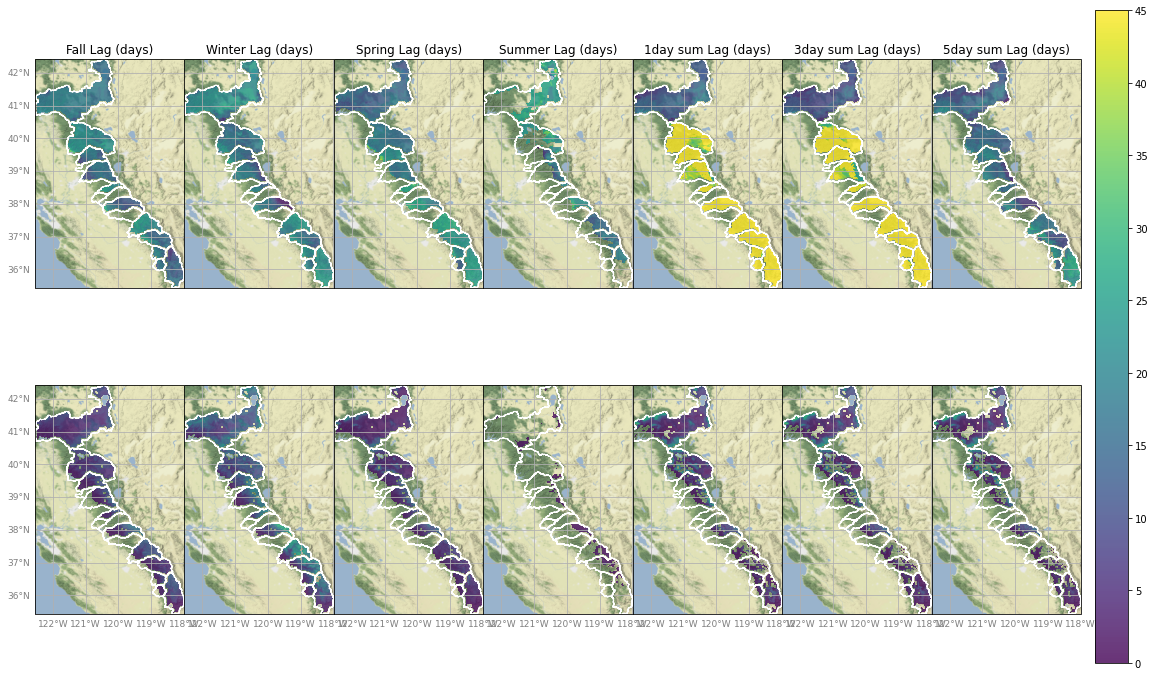

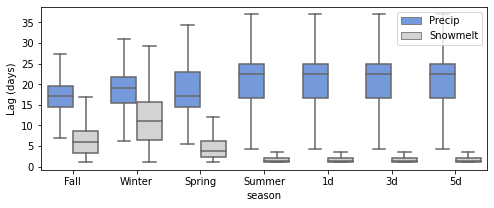

In [7]:
catchments = "../shape/sierra_catchments.shp"

for pvar ,dvar in zip(p_vars[:1], d_vars[:1]):
    print(pvar, dvar)
    
    # Extract the mean ims for each season 
    ims_p = {}
    ims_d = {}
    for seas in ["F", "W", "Sp", "Su"]:
        p_sarr = read_tifs(pvar,seas)
        d_sarr = read_tifs(dvar,seas)
        ims_p[seas] = p_sarr
        ims_d[seas] = d_sarr
        
    for scenario in ["1d", "3d", "5d"]:
        p_sarr = read_ext_tifs(pvar, scenario)
        d_sarr = read_ext_tifs(dvar, scenario)
        ims_p[scenario] = p_sarr
        ims_d[scenario] = d_sarr
    
    # Calc max for plotting colorbars
    pmax = [np.nanmax(x) for k,x in ims_d.items()]
    dmax = [np.nanmax(x) for k,x in ims_p.items()]
    allmax = reject_outliers(np.array(pmax+dmax))
    
    vm = np.nanmax(allmax)
    
    # Plot 
    fig, axes = plt.subplots(nrows=2, ncols=7,figsize = (20,12), subplot_kw={'projection': ccrs.PlateCarree()})
    im = plot_basemaps(ims_p['F'], catchments, "Fall " + var_lookup[dvar], cmap = 'viridis', ax = axes[0][0], latlabels = True, lonlabels = False, vmax = vm)
    plot_basemaps(ims_d['F'], catchments, "", cmap = 'viridis', ax = axes[1][0], latlabels = True, lonlabels = True, vmax = vm)

    plot_basemaps(ims_p['W'], catchments, "Winter " + var_lookup[dvar], cmap = 'viridis', ax = axes[0][1], latlabels = False, lonlabels = False, vmax = vm)
    plot_basemaps(ims_d['W'], catchments, "", cmap = 'viridis', ax = axes[1][1], latlabels = False, lonlabels = True, vmax = vm)

    plot_basemaps(ims_p['Sp'], catchments, "Spring " + var_lookup[dvar], cmap = 'viridis', ax = axes[0][2], latlabels = False, lonlabels = False, vmax = vm)
    plot_basemaps(ims_d['Sp'], catchments, "", cmap = 'viridis', ax = axes[1][2], latlabels = False, lonlabels = True, vmax = vm)

    plot_basemaps(ims_p['Su'], catchments, "Summer " + var_lookup[dvar], cmap = 'viridis', ax = axes[0][3], latlabels = False, lonlabels = False, vmax = vm)
    plot_basemaps(ims_d['Su'], catchments, "", cmap = 'viridis', ax = axes[1][3], latlabels = False, lonlabels = True, vmax = vm)

    plot_basemaps(ims_p['1d'], catchments, "1day sum " + var_lookup[dvar], cmap = 'viridis', ax = axes[0][4], latlabels = False, lonlabels = False, vmax = vm)
    plot_basemaps(ims_d['1d'], catchments, "", cmap = 'viridis', ax = axes[1][4], latlabels = False, lonlabels = True, vmax = vm)
    
    plot_basemaps(ims_p['3d'], catchments, "3day sum " + var_lookup[dvar], cmap = 'viridis', ax = axes[0][5], latlabels = False, lonlabels = False, vmax = vm)
    plot_basemaps(ims_d['3d'], catchments, "", cmap = 'viridis', ax = axes[1][5], latlabels = False, lonlabels = True, vmax = vm)
    
    plot_basemaps(ims_p['5d'], catchments, "5day sum " + var_lookup[dvar], cmap = 'viridis', ax = axes[0][6], latlabels = False, lonlabels = False, vmax = vm)
    plot_basemaps(ims_d['5d'], catchments, "", cmap = 'viridis', ax = axes[1][6], latlabels = False, lonlabels = True, vmax = vm)
    
    for ax, row in zip(axes[:,0], ['Precipitation', 'Snowmelt']):
        ax.set_ylabel(row, rotation=90, size='large')
        
    fig.subplots_adjust(wspace=0.00,hspace =0.00)

#     axes[1][0].set_ylabel("Precipitation")
#     axes[1][1].set_ylabel("Snowmelt")
    
#     fig.subplots_adjust(right=0.8)
#     cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#     fig.colorbar(im, cax=cbar_ax)
    
    fig.colorbar(mappable = im, orientation='vertical', fraction=0.05, pad = 0.0125, ax = axes)
    plt.show()
    
    # Plot boxplots of means 
    pdf = tif2df(pvar,var_type = var_lookup[pvar], var_cat = "Precip")
    sdf = tif2df(dvar,var_type = var_lookup[dvar], var_cat = "Snowmelt")
    
    comdf = pd.concat([pdf,sdf], axis = 0)
    
    plt.figure(figsize=(8,3))
    sns.boxplot(x="season", y=var_lookup[dvar],hue="Variable",data=comdf,
                 showfliers = False, palette=['cornflowerblue','lightgray']).legend(loc='best')
    
    plt.show()

In [8]:
sdf.season.unique()

array(['Fall', 'Winter', 'Spring', 'Summer', '1d', '3d', '5d'],
      dtype=object)

# Create elevation contours

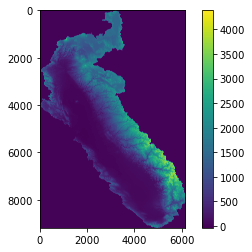

In [9]:

src = rio.open("../rasters/hu6_srtm_dem.tif")
arr = src.read(1)
plt.imshow(arr)
plt.colorbar()

# Cd into the ../rasters and run: 


```gdal_contour -a 'elev' hu6_srtm_dem.tif ../shape/contours_500m.shp -i 500.0 -p```

<ipython-input-10-c15115718ded>:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_under('k', alpha=0)


<AxesSubplot:title={'center':'500m elevation contours '}>

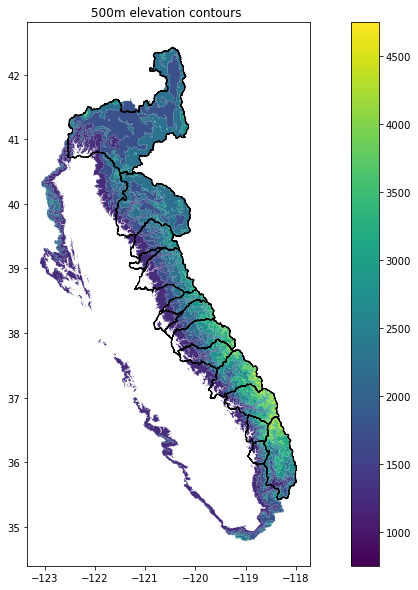

In [10]:
# Read contours we made 
cont_gdf = gp.read_file("../shape/contours_500m.shp")
cont_gdf['elev'] = np.linspace(250,4750,10) # [int(x) * 500 for x in gdf['ID']] 

# Set alpha val in cmap
cmap = plt.get_cmap('viridis')
cmap.set_under('k', alpha=0)

# plot with watersehds 
ax = cont_gdf.plot(figsize = (15,10), column= 'elev',cmap = cmap, legend = True, vmin = 751)
plt.title('500m elevation contours ')
gp.read_file("../shape/sierra_catchments.shp").plot(ax = ax, facecolor = "none", edgecolor = 'black')

In [11]:
len(cont_gdf)

10

In [12]:
# Define the 500m contour interval 

heights = np.linspace(0,5000,11)
heights = ["{} - {}".format(str(x-500), str(x)) for x in heights]
heights[0] = "<0"

median_hts = np.linspace(250,4750,10)

In [13]:
# Read each contour interval shape

with fiona.open("../shape/contours_500m.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

len(shapes)

10

In [14]:
# Setup dicts to house final results
season_res_p = {}
season_res_d = {}

# loop through seasons
for season in seasons[:]: 
    
    # setup dict for seasonal results
    variable_res_p = {}
    variable_res_d = {}
    
    # loop through precip vars 
    for hvarname in tqdm(p_vars[:]):
                
        # find the merged file
        vardir = os.path.join("../rasters/seasonal_merged",hvarname)
        seasonal_var_fn = [os.path.join(vardir,x) for x in os.listdir(vardir) if season in x]
        
        # Set up dict for elevation results
        elev_res = {}
        
        # Loop through elevation contours
        for idx, shape in enumerate(shapes):
            with rasterio.open(seasonal_var_fn[0]) as src:
                out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
                outim = out_image.reshape(out_image.shape[1],out_image.shape[2])
                outim[outim==-999]=np.nan #mask nodata vals 
                
                elev_res[heights[idx]] = outim[~np.isnan(outim)].flatten()
                
        # Compile summary stats for each elevation bin 
        df_rows = []
        for k,v in elev_res.items():
            varmean = np.nanmean(v)
            varstd = np.nanstd(v)
            var_n = len(v)
            sumdf = pd.DataFrame([k,varmean,varstd,var_n]).T
            sumdf.columns = ['elev','{}_mean'.format(hvarname),'{}_std'.format(hvarname),'{}_num'.format(hvarname)]
            df_rows.append(sumdf)
            
        # Concat the stats we just extracted 
        tdf = pd.concat(df_rows)
        tdf['elev'] = np.linspace(250,4750,10)
        tdf = tdf.astype(float).set_index("elev")
        
        variable_res_p[hvarname] = tdf
        
    seasonal_df_p = pd.concat([v for k,v in variable_res_p.items()], axis = 1)
    season_res_p[season] = seasonal_df_p
    
    
    # loop through dswe vars 
    for hvarname in tqdm(d_vars[:]):
                
        # find the merged file
        vardir = os.path.join("../rasters/seasonal_merged",hvarname)
        seasonal_var_fn = [os.path.join(vardir,x) for x in os.listdir(vardir) if season in x]
        
        # Set up dict for elevation results
        elev_res = {}
        
        # Loop through elevation contours
        for idx, shape in enumerate(shapes):
            with rasterio.open(seasonal_var_fn[0]) as src:
                out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
                outim = out_image.reshape(out_image.shape[1],out_image.shape[2])
                outim[outim==-999]=np.nan #mask nodata vals 
                
                elev_res[heights[idx]] = outim[~np.isnan(outim)].flatten()
                
        # Compile summary stats for each elevation bin 
        df_rows = []
        for k,v in elev_res.items():
            varmean = np.nanmean(v)
            varstd = np.nanstd(v)
            var_n = len(v)
            sumdf = pd.DataFrame([k,varmean,varstd,var_n]).T
            sumdf.columns = ['elev','{}_mean'.format(hvarname),'{}_std'.format(hvarname),'{}_num'.format(hvarname)]
            df_rows.append(sumdf)
            
        # Concat the stats we just extracted 
        tdf = pd.concat(df_rows)
        tdf['elev'] = np.linspace(250,4750,10)
        tdf = tdf.astype(float).set_index("elev")
        
        variable_res_d[hvarname] = tdf
        
    seasonal_df_d = pd.concat([v for k,v in variable_res_d.items()], axis = 1)
    season_res_d[season] = seasonal_df_d

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-14-cd4938740bed>:34: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-14-cd4938740bed>:74: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
100%|██████████| 5/5 [01:15<00:00, 15.11s/it]


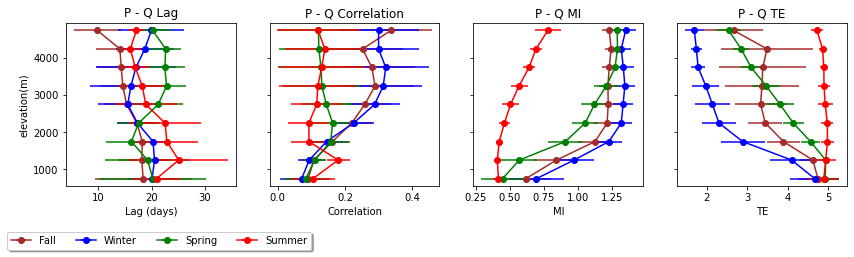

In [15]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(14, 3))

ax0.set_title("P - Q Lag")

ax0.errorbar(season_res_p['F']['plag_mean'], season_res_p['F'].index, xerr =season_res_p['F']['plag_std'],label = 'Fall', color = 'brown',marker='o' )
ax0.errorbar(season_res_p['W']['plag_mean'], season_res_p['F'].index, xerr =season_res_p['W']['plag_std'],label = 'Winter', color = 'blue',marker='o' )
ax0.errorbar(season_res_p['Sp']['plag_mean'], season_res_p['F'].index, xerr =season_res_p['Sp']['plag_std'],label = 'Spring', color = 'green',marker='o' )
ax0.errorbar(season_res_p['Su']['plag_mean'], season_res_p['F'].index, xerr =season_res_p['Su']['plag_std'],label = 'Summer', color = 'red',marker='o' )

ax0.set_ylabel("elevation(m)")
ax0.set_xlabel("Lag (days)")

ax0.legend()

ax0.legend(loc='upper center', bbox_to_anchor=(0.55, -.25), ncol=4, fancybox=True, shadow=True)


ax1.set_title("P - Q Correlation")

ax1.errorbar(season_res_p['F']['pcor_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pcor_std'],color = 'brown',marker='o' )
ax1.errorbar(season_res_p['W']['pcor_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pcor_std'], color = 'blue',marker='o' )
ax1.errorbar(season_res_p['Sp']['pcor_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pcor_std'], color = 'green',marker='o' )
ax1.errorbar(season_res_p['Su']['pcor_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pcor_std'], color = 'red',marker='o' )

ax1.set_xlabel("Correlation")

ax2.set_title("P - Q MI")

ax2.errorbar(season_res_p['F']['pmi_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pmi_std'],color = 'brown',marker='o' )
ax2.errorbar(season_res_p['W']['pmi_mean'], season_res_p['F'].index, xerr =season_res_p['W']['pmi_std'], color = 'blue',marker='o' )
ax2.errorbar(season_res_p['Sp']['pmi_mean'], season_res_p['F'].index, xerr =season_res_p['Sp']['pmi_std'], color = 'green',marker='o' )
ax2.errorbar(season_res_p['Su']['pmi_mean'], season_res_p['F'].index, xerr =season_res_p['Su']['pmi_std'], color = 'red',marker='o' )

ax2.set_xlabel("MI")

ax3.set_title("P - Q TE")

ax3.errorbar(season_res_p['F']['pte_mean'], season_res_p['F'].index, xerr = season_res_p['F']['pte_std'],color = 'brown',marker='o' )
ax3.errorbar(season_res_p['W']['pte_mean'], season_res_p['F'].index, xerr = season_res_p['W']['pte_std'], color = 'blue',marker='o' )
ax3.errorbar(season_res_p['Sp']['pte_mean'], season_res_p['F'].index, xerr = season_res_p['Sp']['pte_std'], color = 'green',marker='o' )
ax3.errorbar(season_res_p['Su']['pte_mean'], season_res_p['F'].index, xerr = season_res_p['Su']['pte_std'], color = 'red',marker='o' )

ax3.set_xlabel("TE")

plt.show()

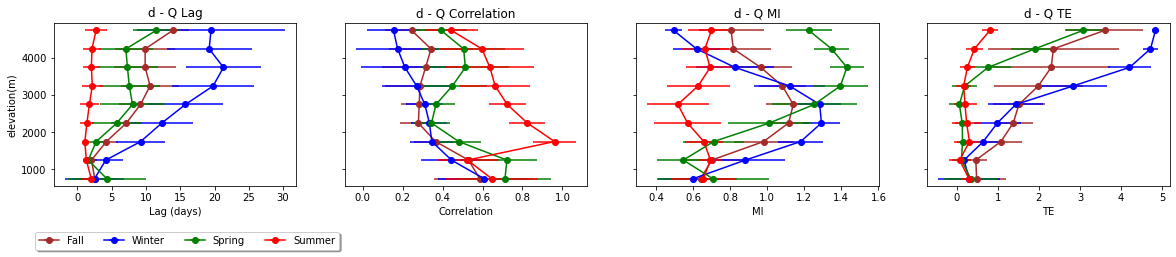

In [16]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(20, 3))

ax0.set_title("d - Q Lag")

ax0.errorbar(season_res_d['F']['dlag_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dlag_std'],label = 'Fall', color = 'brown',marker='o' )
ax0.errorbar(season_res_d['W']['dlag_mean'], season_res_d['F'].index, xerr =season_res_d['W']['dlag_std'],label = 'Winter', color = 'blue',marker='o' )
ax0.errorbar(season_res_d['Sp']['dlag_mean'], season_res_d['F'].index, xerr =season_res_d['Sp']['dlag_std'],label = 'Spring', color = 'green',marker='o' )
ax0.errorbar(season_res_d['Su']['dlag_mean'], season_res_d['F'].index, xerr =season_res_d['Su']['dlag_std'],label = 'Summer', color = 'red',marker='o' )

ax0.set_ylabel("elevation(m)")
ax0.set_xlabel("Lag (days)")

ax0.legend()

ax0.legend(loc='upper center', bbox_to_anchor=(0.55, -.25), ncol=4, fancybox=True, shadow=True)


ax1.set_title("d - Q Correlation")

ax1.errorbar(season_res_d['F']['dcor_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dcor_std'],color = 'brown',marker='o' )
ax1.errorbar(season_res_d['W']['dcor_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dcor_std'], color = 'blue',marker='o' )
ax1.errorbar(season_res_d['Sp']['dcor_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dcor_std'], color = 'green',marker='o' )
ax1.errorbar(season_res_d['Su']['dcor_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dcor_std'], color = 'red',marker='o' )

ax1.set_xlabel("Correlation")

ax2.set_title("d - Q MI")

ax2.errorbar(season_res_d['F']['dmi_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dmi_std'],color = 'brown',marker='o' )
ax2.errorbar(season_res_d['W']['dmi_mean'], season_res_d['F'].index, xerr =season_res_d['W']['dmi_std'], color = 'blue',marker='o' )
ax2.errorbar(season_res_d['Sp']['dmi_mean'], season_res_d['F'].index, xerr =season_res_d['Sp']['dmi_std'], color = 'green',marker='o' )
ax2.errorbar(season_res_d['Su']['dmi_mean'], season_res_d['F'].index, xerr =season_res_d['Su']['dmi_std'], color = 'red',marker='o' )

ax2.set_xlabel("MI")

ax3.set_title("d - Q TE")

ax3.errorbar(season_res_d['F']['dte_mean'], season_res_d['F'].index, xerr = season_res_d['F']['dte_std'],color = 'brown',marker='o' )
ax3.errorbar(season_res_d['W']['dte_mean'], season_res_d['F'].index, xerr = season_res_d['W']['dte_std'], color = 'blue',marker='o' )
ax3.errorbar(season_res_d['Sp']['dte_mean'], season_res_d['F'].index, xerr = season_res_d['Sp']['dte_std'], color = 'green',marker='o' )
ax3.errorbar(season_res_d['Su']['dte_mean'], season_res_d['F'].index, xerr = season_res_d['Su']['dte_std'], color = 'red',marker='o' )

ax3.set_xlabel("TE")

plt.show()

In [17]:
numcols_d = [x for x in season_res_d['Su'].columns if "num" in x]

numdfs_d = []

for season in seasons:
    sdf = pd.DataFrame(season_res_d[season][numcols_d].mean(axis = 1))
    sdf.columns = [season]
    numdfs_d.append(sdf)
    
seasdf_d = pd.concat(numdfs_d, axis = 1)

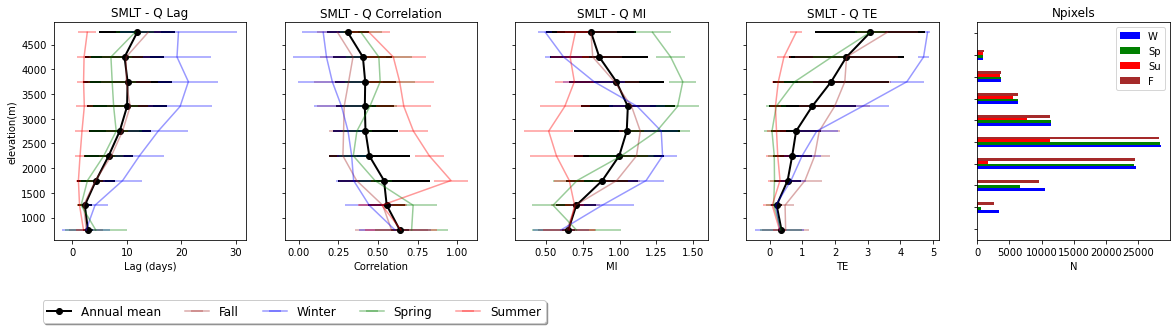

In [18]:
# Plot all metrics as f(elevation) for SNOWMELT

plt.figure(figsize=(20,4))

ax0 = plt.subplot(151)
ax0.set_title("SMLT - Q Lag")
varmean = pd.concat([season_res_d[key]['dlag_mean'] for key in season_res_d.keys()], axis=1).mean(axis = 1)
varstd = pd.concat([season_res_d[key]['dlag_mean'] for key in season_res_d.keys()], axis=1).std(axis = 1)
ax0.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax0.errorbar(season_res_d['F']['dlag_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dlag_std'],label = 'Fall', color = 'brown', alpha = 0.4)
ax0.errorbar(season_res_d['W']['dlag_mean'], season_res_d['F'].index, xerr =season_res_d['W']['dlag_std'],label = 'Winter', color = 'blue',alpha = 0.4 )
ax0.errorbar(season_res_d['Sp']['dlag_mean'], season_res_d['F'].index, xerr =season_res_d['Sp']['dlag_std'],label = 'Spring', color = 'green',alpha = 0.4 )
ax0.errorbar(season_res_d['Su']['dlag_mean'], season_res_d['F'].index, xerr =season_res_d['Su']['dlag_std'],label = 'Summer', color = 'red', alpha = 0.4 )

ax0.set_ylabel("elevation(m)")
ax0.set_xlabel("Lag (days)")

ax0.legend()

ax0.legend(loc='upper center', bbox_to_anchor=(1.25, -.25), ncol=5, fontsize = 12, fancybox=True, shadow=True)


ax1 = plt.subplot(152)
ax1.set_title("SMLT - Q Correlation")
varmean = pd.concat([season_res_d[key]['dcor_mean'] for key in season_res_d.keys()], axis=1).mean(axis = 1)
varstd = pd.concat([season_res_d[key]['dcor_mean'] for key in season_res_d.keys()], axis=1).std(axis = 1)
ax1.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax1.errorbar(season_res_d['F']['dcor_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dcor_std'],color = 'brown', alpha = 0.4)
ax1.errorbar(season_res_d['W']['dcor_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dcor_std'], color = 'blue', alpha = 0.4)
ax1.errorbar(season_res_d['Sp']['dcor_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dcor_std'], color = 'green', alpha = 0.4 )
ax1.errorbar(season_res_d['Su']['dcor_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dcor_std'], color = 'red', alpha = 0.4)
ax1.set(yticklabels=[])  
ax1.set_xlabel("Correlation")

ax2 = plt.subplot(153)
ax2.set_title("SMLT - Q MI")
varmean = pd.concat([season_res_d[key]['dmi_mean'] for key in season_res_d.keys()], axis=1).mean(axis = 1)
varstd = pd.concat([season_res_d[key]['dmi_mean'] for key in season_res_d.keys()], axis=1).std(axis = 1)
ax2.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax2.errorbar(season_res_d['F']['dmi_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dmi_std'],color = 'brown', alpha = 0.4 )
ax2.errorbar(season_res_d['W']['dmi_mean'], season_res_d['F'].index, xerr =season_res_d['W']['dmi_std'], color = 'blue', alpha = 0.4 )
ax2.errorbar(season_res_d['Sp']['dmi_mean'], season_res_d['F'].index, xerr =season_res_d['Sp']['dmi_std'], color = 'green', alpha = 0.4 )
ax2.errorbar(season_res_d['Su']['dmi_mean'], season_res_d['F'].index, xerr =season_res_d['Su']['dmi_std'], color = 'red', alpha = 0.4 )
ax2.set(yticklabels=[])  
ax2.set_xlabel("MI")

ax3 = plt.subplot(154)
ax3.set_title("SMLT - Q TE")
varmean = pd.concat([season_res_d[key]['dte_mean'] for key in season_res_d.keys()], axis=1).mean(axis = 1)
varstd = pd.concat([season_res_d[key]['dte_mean'] for key in season_res_d.keys()], axis=1).std(axis = 1)
ax3.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax3.errorbar(season_res_d['F']['dte_mean'], season_res_d['F'].index, xerr = season_res_d['F']['dte_std'],color = 'brown', alpha = 0.4)
ax3.errorbar(season_res_d['W']['dte_mean'], season_res_d['F'].index, xerr = season_res_d['W']['dte_std'], color = 'blue', alpha = 0.4)
ax3.errorbar(season_res_d['Sp']['dte_mean'], season_res_d['F'].index, xerr = season_res_d['Sp']['dte_std'], color = 'green', alpha = 0.4)
ax3.errorbar(season_res_d['Su']['dte_mean'], season_res_d['F'].index, xerr = season_res_d['Su']['dte_std'], color = 'red', alpha = 0.4)
ax3.set(yticklabels=[])  
ax3.set_xlabel("TE")

plt.subplot(155)
ax4 = seasdf_d.plot(kind = 'barh', ax = plt.gca(),color = ['blue', 'green', 'red', 'brown'])
ax4.set(yticklabels=[])  
ax4.set_ylabel("")  
ax4.set_xlabel("N")  
ax4.set_title("Npixels")
plt.show()

In [19]:
numcols_p = [x for x in season_res_p['Su'].columns if "num" in x]

numdfs_p = []

for season in seasons:
    sdf = pd.DataFrame(season_res_p[season][numcols_p].mean(axis = 1))
    sdf.columns = [season]
    numdfs_p.append(sdf)
    
seasdf_p = pd.concat(numdfs_p, axis = 1)

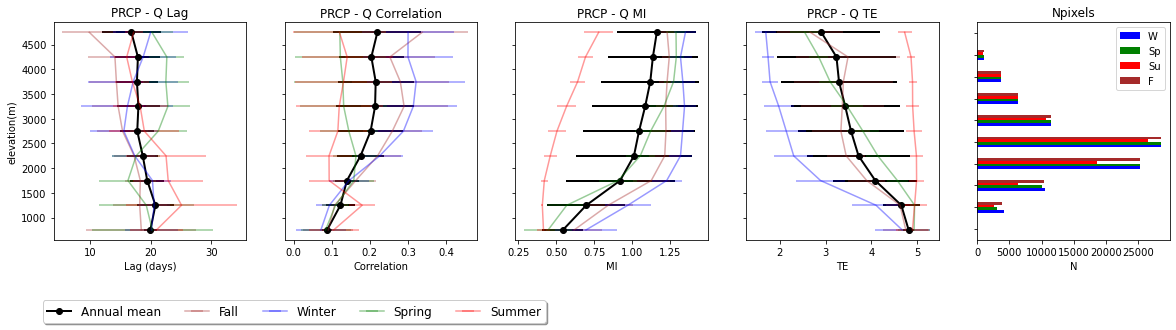

In [20]:
# Plot all metrics as f(elevation) for Liquid Precip

plt.figure(figsize=(20,4))

ax0 = plt.subplot(151)
ax0.set_title("PRCP - Q Lag")
varmean = pd.concat([season_res_p[key]['plag_mean'] for key in season_res_p.keys()], axis=1).mean(axis = 1)
varstd = pd.concat([season_res_p[key]['plag_mean'] for key in season_res_p.keys()], axis=1).std(axis = 1)
ax0.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax0.errorbar(season_res_p['F']['plag_mean'], season_res_p['F'].index, xerr =season_res_p['F']['plag_std'],label = 'Fall', color = 'brown',alpha = 0.4)
ax0.errorbar(season_res_p['W']['plag_mean'], season_res_p['F'].index, xerr =season_res_p['W']['plag_std'],label = 'Winter', color = 'blue',alpha = 0.4)
ax0.errorbar(season_res_p['Sp']['plag_mean'], season_res_p['F'].index, xerr =season_res_p['Sp']['plag_std'],label = 'Spring', color = 'green',alpha = 0.4)
ax0.errorbar(season_res_p['Su']['plag_mean'], season_res_p['F'].index, xerr =season_res_p['Su']['plag_std'],label = 'Summer', color = 'red',alpha = 0.4)

ax0.set_ylabel("elevation(m)")
ax0.set_xlabel("Lag (days)")

ax0.legend(loc='upper center', bbox_to_anchor=(1.25, -.25), ncol=5, fontsize = 12, fancybox=True, shadow=True)


ax1 = plt.subplot(152)
ax1.set_title("PRCP - Q Correlation")
varmean = pd.concat([season_res_p[key]['pcor_mean'] for key in season_res_p.keys()], axis=1).mean(axis = 1)
varstd = pd.concat([season_res_p[key]['pcor_mean'] for key in season_res_p.keys()], axis=1).std(axis = 1)
ax1.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax1.errorbar(season_res_p['F']['pcor_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pcor_std'],color = 'brown',alpha = 0.4)
ax1.errorbar(season_res_p['W']['pcor_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pcor_std'], color = 'blue',alpha = 0.4)
ax1.errorbar(season_res_p['Sp']['pcor_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pcor_std'], color = 'green',alpha = 0.4)
ax1.errorbar(season_res_p['Su']['pcor_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pcor_std'], color = 'red',alpha = 0.4)
ax1.set(yticklabels=[])  
ax1.set_xlabel("Correlation")

ax2 = plt.subplot(153)
ax2.set_title("PRCP - Q MI")
varmean = pd.concat([season_res_p[key]['pmi_mean'] for key in season_res_p.keys()], axis=1).mean(axis = 1)
varstd = pd.concat([season_res_p[key]['pmi_mean'] for key in season_res_p.keys()], axis=1).std(axis = 1)
ax2.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax2.errorbar(season_res_p['F']['pmi_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pmi_std'],color = 'brown',alpha = 0.4)
ax2.errorbar(season_res_p['W']['pmi_mean'], season_res_p['F'].index, xerr =season_res_p['W']['pmi_std'], color = 'blue',alpha = 0.4)
ax2.errorbar(season_res_p['Sp']['pmi_mean'], season_res_p['F'].index, xerr =season_res_p['Sp']['pmi_std'], color = 'green',alpha = 0.4)
ax2.errorbar(season_res_p['Su']['pmi_mean'], season_res_p['F'].index, xerr =season_res_p['Su']['pmi_std'], color = 'red',alpha = 0.4)
ax2.set(yticklabels=[])  
ax2.set_xlabel("MI")

ax3 = plt.subplot(154)
ax3.set_title("PRCP - Q TE")
varmean = pd.concat([season_res_p[key]['pte_mean'] for key in season_res_p.keys()], axis=1).mean(axis = 1)
varstd = pd.concat([season_res_p[key]['pte_mean'] for key in season_res_p.keys()], axis=1).std(axis = 1)
ax3.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax3.errorbar(season_res_p['F']['pte_mean'], season_res_p['F'].index, xerr = season_res_p['F']['pte_std'],color = 'brown',alpha = 0.4)
ax3.errorbar(season_res_p['W']['pte_mean'], season_res_p['F'].index, xerr = season_res_p['W']['pte_std'], color = 'blue',alpha = 0.4)
ax3.errorbar(season_res_p['Sp']['pte_mean'], season_res_p['F'].index, xerr = season_res_p['Sp']['pte_std'], color = 'green',alpha = 0.4)
ax3.errorbar(season_res_p['Su']['pte_mean'], season_res_p['F'].index, xerr = season_res_p['Su']['pte_std'], color = 'red',alpha = 0.4)
ax3.set(yticklabels=[])  
ax3.set_xlabel("TE")

plt.subplot(155)
ax4 = seasdf_p.plot(kind = 'barh', ax = plt.gca(),color = ['blue', 'green', 'red', 'brown'])
ax4.set(yticklabels=[])  
ax4.set_ylabel("")  
ax4.set_xlabel("N")  
ax4.set_title("Npixels")

plt.show()

# Plot for each watershed 

In [21]:
# Setup dicts to house final results
season_res_p_sheds = {}
season_res_d_sheds = {}

# Loop through watersheds 
for idx, x in enumerate(gdf[:].iterrows()):
    
    season_res_p = {}
    season_res_d = {}
    
    print("****" * 15)
    row  = x[1]
    stn_id = row['stid']    
    if stn_id == "MCR" or stn_id == "CFW" or stn_id == "NHG":
        continue
        print("No Reservoir data for {}".format(stn_id))
        
    catch_shp = "../shape/{}.shp".format(stn_id)
    print("PROCESSING : ", stn_id, row['catch_name'])
    
    # Merge the contours and watershed
    shed_elevs = gp.overlay(cont_gdf, gp.read_file(catch_shp), how='intersection')
    if not os.path.exists("../shape/shed_cons"):
        os.mkdir("../shape/shed_cons")
    shed_elevs.to_file("../shape/shed_cons/{}.shp".format(stn_id))
    
    # Read teh shapes 
    with fiona.open("../shape/shed_cons/{}.shp".format(stn_id), "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
        elevs = [feature['properties']['elev'] for feature in shapefile]

    # Setup dicts to house seasonal results
    season_res_p = {}
    season_res_d = {}

    # loop through seasons
    for season in seasons[:]: 

        # setup dict for seasonal results
        variable_res_p = {}
        variable_res_d = {}

        # loop through precip vars 
        for hvarname in tqdm(p_vars[:]):

            # find the merged file
            vardir = os.path.join("../rasters/seasonal_merged",hvarname)
            seasonal_var_fn = [os.path.join(vardir,x) for x in os.listdir(vardir) if season in x]

            # Set up dict for elevation results
            elev_res = {}

            # Loop through elevation contours
            for idx, shape in enumerate(shapes):
                with rasterio.open(seasonal_var_fn[0]) as src:
                    out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
                    outim = out_image.reshape(out_image.shape[1],out_image.shape[2])
                    outim[outim==-999]=np.nan #mask nodata vals 

                    elev_res[heights[idx]] = outim[~np.isnan(outim)].flatten()

            # Compile summary stats for each elevation bin 
            df_rows = []
            for k,v in elev_res.items():
                varmean = np.nanmean(v)
                varstd = np.nanstd(v)
                var_n = len(v)
                sumdf = pd.DataFrame([k,varmean,varstd,var_n]).T
                sumdf.columns = ['elev','{}_mean'.format(hvarname),'{}_std'.format(hvarname),'{}_num'.format(hvarname)]
                df_rows.append(sumdf)

            # Concat the stats we just extracted 
            tdf = pd.concat(df_rows)
            tdf['elev'] = elevs
            tdf = tdf.astype(float).set_index("elev")

            variable_res_p[hvarname] = tdf

        seasonal_df_p = pd.concat([v for k,v in variable_res_p.items()], axis = 1)
        season_res_p[season] = seasonal_df_p


        # loop through dswe vars 
        for hvarname in tqdm(d_vars[:]):

            # find the merged file
            vardir = os.path.join("../rasters/seasonal_merged",hvarname)
            seasonal_var_fn = [os.path.join(vardir,x) for x in os.listdir(vardir) if season in x]

            # Set up dict for elevation results
            elev_res = {}

            # Loop through elevation contours
            for idx, shape in enumerate(shapes):
                with rasterio.open(seasonal_var_fn[0]) as src:
                    out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
                    outim = out_image.reshape(out_image.shape[1],out_image.shape[2])
                    outim[outim==-999]=np.nan #mask nodata vals 

                    elev_res[heights[idx]] = outim[~np.isnan(outim)].flatten()

            # Compile summary stats for each elevation bin 
            df_rows = []
            for k,v in elev_res.items():
                varmean = np.nanmean(v)
                varstd = np.nanstd(v)
                var_n = len(v)
                sumdf = pd.DataFrame([k,varmean,varstd,var_n]).T
                sumdf.columns = ['elev','{}_mean'.format(hvarname),'{}_std'.format(hvarname),'{}_num'.format(hvarname)]
                df_rows.append(sumdf)

            # Concat the stats we just extracted 
            tdf = pd.concat(df_rows)
            tdf['elev'] = elevs
            tdf = tdf.astype(float).set_index("elev")

            variable_res_d[hvarname] = tdf

        seasonal_df_d = pd.concat([v for k,v in variable_res_d.items()], axis = 1)
        season_res_d[season] = seasonal_df_d
        
    season_res_d_sheds[stn_id] = season_res_d
    season_res_p_sheds[stn_id] = season_res_p

************************************************************
PROCESSING :  ENG YUBA R


  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:105: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:65: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
100%|██████████| 5/5 [00:00<00:00,  9.26it/s]


************************************************************
PROCESSING :  PAR MOKELUMNE R


  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:65: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:105: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
100%|██████████| 5/5 [00:00<00:00, 13.30it/s]


************************************************************
PROCESSING :  MIL SAN JOAQUIN R


  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:65: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 20%|██        | 1/5 [00:00<00:00,  4.95it/s]<ipython-input-21-df3a9cbfdf09>:105: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


************************************************************
PROCESSING :  ISB KERN R


  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:65: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:105: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
100%|██████████| 5/5 [00:01<00:00,  4.02it/s]


************************************************************
PROCESSING :  DNP TUOLUMNE R


  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:65: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:105: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
100%|██████████| 5/5 [00:00<00:00,  6.49it/s]


************************************************************
PROCESSING :  NML STANISLAUS R


  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:65: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:105: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
100%|██████████| 5/5 [00:00<00:00,  9.50it/s]


************************************************************
PROCESSING :  ORO FEATHER R


  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:65: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:105: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


************************************************************
PROCESSING :  FOL AMERICAN R


  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:65: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:105: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
100%|██████████| 5/5 [00:01<00:00,  4.89it/s]


************************************************************
PROCESSING :  TRM KAWEAH R


  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:65: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:105: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
100%|██████████| 5/5 [00:00<00:00, 12.26it/s]


************************************************************
PROCESSING :  SCC TULE R


  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:65: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 40%|████      | 2/5 [00:00<00:00, 11.14it/s]<ipython-input-21-df3a9cbfdf09>:105: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
100%|██████████| 5/5 [00:00<00:00, 23.32it/s]


************************************************************
************************************************************
PROCESSING :  PNF KINGS R


  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:65: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:105: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


************************************************************
************************************************************
************************************************************
PROCESSING :  SHA SACRAMENTO R


  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:65: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-21-df3a9cbfdf09>:105: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


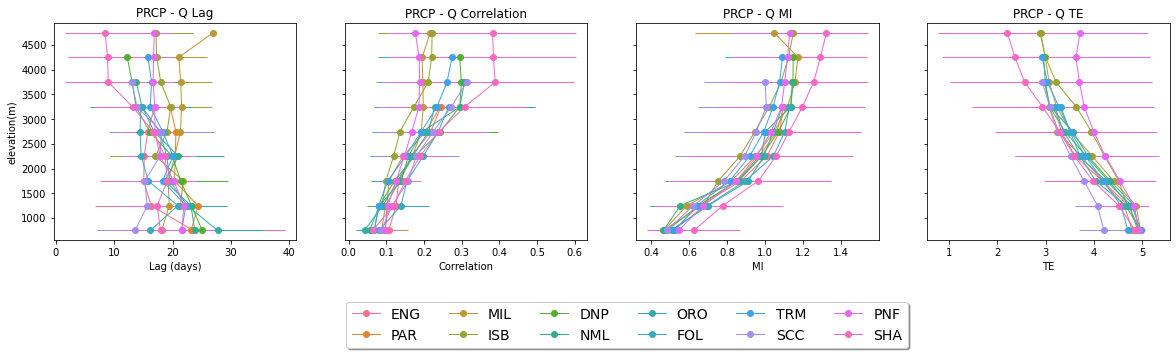

In [22]:
# Get enough colors for each watershed to be unique
colors = sns.color_palette("husl", len(season_res_p_sheds.keys()))
cdict = OrderedDict(zip(list(gdf[~gdf['stid'].isin(['CFW', 'MCR', 'NHG'])]['stid']),colors))


# Setup fig
plt.figure(figsize=(20,4))


# Loop through results
for k,v in season_res_p_sheds.items():
    stid = k
    season_res_p = v
    varmean = pd.concat([season_res_p[key]['plag_mean'] for key in season_res_p.keys()], axis=1).mean(axis = 1)
    varstd = pd.concat([season_res_p[key]['plag_mean'] for key in season_res_p.keys()], axis=1).std(axis = 1)

    ax0 = plt.subplot(141)
    ax0.set_title("PRCP - Q Lag")
    varmean = pd.concat([season_res_p[key]['plag_mean'] for key in season_res_p.keys()], axis=1).mean(axis = 1)
    varstd = pd.concat([season_res_p[key]['plag_mean'] for key in season_res_p.keys()], axis=1).std(axis = 1)
    ax0.errorbar(varmean,varmean.index, xerr = varstd, label = k, linewidth = 1,marker='o', c= cdict[stid])
    ax0.set_ylabel("elevation(m)")
    ax0.set_xlabel("Lag (days)")
    
    ax1 = plt.subplot(142)
    ax1.set_title("PRCP - Q Correlation")
    varmean = pd.concat([season_res_p[key]['pcor_mean'] for key in season_res_p.keys()], axis=1).mean(axis = 1)
    varstd = pd.concat([season_res_p[key]['pcor_mean'] for key in season_res_p.keys()], axis=1).std(axis = 1)
    ax1.errorbar(varmean,varmean.index, xerr = varstd, label = k, linewidth = 1,marker='o',c= cdict[stid])
    ax1.set(yticklabels=[])  
    ax1.set_xlabel("Correlation")

    ax2 = plt.subplot(143)
    ax2.set_title("PRCP - Q MI")
    varmean = pd.concat([season_res_p[key]['pmi_mean'] for key in season_res_p.keys()], axis=1).mean(axis = 1)
    varstd = pd.concat([season_res_p[key]['pmi_mean'] for key in season_res_p.keys()], axis=1).std(axis = 1)
    ax2.errorbar(varmean,varmean.index, xerr = varstd,  label = k, linewidth = 1,marker='o',c= cdict[stid])
    ax2.set(yticklabels=[])  
    ax2.set_xlabel("MI")

    ax3 = plt.subplot(144)
    ax3.set_title("PRCP - Q TE")
    varmean = pd.concat([season_res_p[key]['pte_mean'] for key in season_res_p.keys()], axis=1).mean(axis = 1)
    varstd = pd.concat([season_res_p[key]['pte_mean'] for key in season_res_p.keys()], axis=1).std(axis = 1)
    ax3.errorbar(varmean,varmean.index, xerr = varstd,  label = k, linewidth = 1,marker='o',c= cdict[stid])
    ax3.set(yticklabels=[])  
    ax3.set_xlabel("TE")

plt.legend(loc='upper right', bbox_to_anchor=(-0.05, -.25), ncol=6, fontsize = 14, fancybox=True, shadow=True)
plt.show()

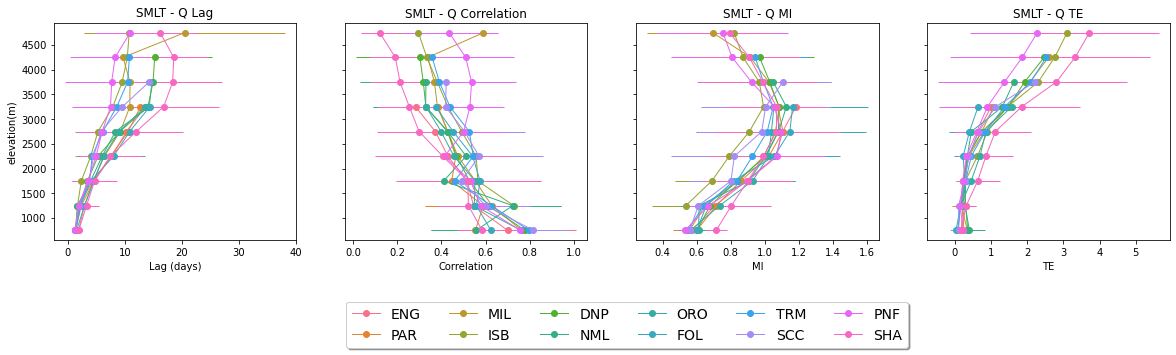

In [23]:
# Get enough colors for each watershed to be unique
colors = sns.color_palette("husl", len(season_res_p_sheds.keys()))
cdict = OrderedDict(zip(list(gdf[~gdf['stid'].isin(['CFW', 'MCR', 'NHG'])]['stid']),colors))


# Setup fig
plt.figure(figsize=(20,4))


# Loop through results
for k,v in season_res_d_sheds.items():
    stid = k
    season_res_d = v
    varmean = pd.concat([season_res_d[key]['dlag_mean'] for key in season_res_d.keys()], axis=1).mean(axis = 1)
    varstd = pd.concat([season_res_d[key]['dlag_mean'] for key in season_res_d.keys()], axis=1).std(axis = 1)

    ax0 = plt.subplot(141)
    ax0.set_title("SMLT - Q Lag")
    varmean = pd.concat([season_res_d[key]['dlag_mean'] for key in season_res_d.keys()], axis=1).mean(axis = 1)
    varstd = pd.concat([season_res_d[key]['dlag_mean'] for key in season_res_d.keys()], axis=1).std(axis = 1)
    ax0.errorbar(varmean,varmean.index, xerr = varstd, label = k, linewidth = 1,marker='o', c= cdict[stid])
    ax0.set_ylabel("elevation(m)")
    ax0.set_xlabel("Lag (days)")
    
    ax1 = plt.subplot(142)
    ax1.set_title("SMLT - Q Correlation")
    varmean = pd.concat([season_res_d[key]['dcor_mean'] for key in season_res_d.keys()], axis=1).mean(axis = 1)
    varstd = pd.concat([season_res_d[key]['dcor_mean'] for key in season_res_d.keys()], axis=1).std(axis = 1)
    ax1.errorbar(varmean,varmean.index, xerr = varstd, label = k, linewidth = 1,marker='o',c= cdict[stid])
    ax1.set(yticklabels=[])  
    ax1.set_xlabel("Correlation")

    ax2 = plt.subplot(143)
    ax2.set_title("SMLT - Q MI")
    varmean = pd.concat([season_res_d[key]['dmi_mean'] for key in season_res_d.keys()], axis=1).mean(axis = 1)
    varstd = pd.concat([season_res_d[key]['dmi_mean'] for key in season_res_d.keys()], axis=1).std(axis = 1)
    ax2.errorbar(varmean,varmean.index, xerr = varstd,  label = k, linewidth = 1,marker='o',c= cdict[stid])
    ax2.set(yticklabels=[])  
    ax2.set_xlabel("MI")

    ax3 = plt.subplot(144)
    ax3.set_title("SMLT - Q TE")
    varmean = pd.concat([season_res_d[key]['dte_mean'] for key in season_res_d.keys()], axis=1).mean(axis = 1)
    varstd = pd.concat([season_res_d[key]['dte_mean'] for key in season_res_d.keys()], axis=1).std(axis = 1)
    ax3.errorbar(varmean,varmean.index, xerr = varstd,  label = k, linewidth = 1,marker='o',c= cdict[stid])
    ax3.set(yticklabels=[])  
    ax3.set_xlabel("TE")

plt.legend(loc='upper right', bbox_to_anchor=(-0.05, -.25), ncol=6, fontsize = 14, fancybox=True, shadow=True)
plt.show()